In [ ]:
import torch
import torch.nn as nn
from snn_delays.snn import SNN
from torch.autograd import Function
import torch.nn.functional as F
import numpy as np

def modify_weights(layer, value, mode='mask', trainable=True):
    """
    Function to mask weights

    :param layer: a snn layer (e.g: )
    :param value: a Tensor or numpy array
    :param mode: ily current weights by value, 
                 if 'replf 'mask' multipace' assign new value to weights 
    :param trainable: (default = True)
    """

    #print(layer.device)
    #device = layer.device

    value = torch.Tensor(value).to(layer.weight.device)

    if layer.weight.data.shape == value.shape:
        new_weight = value if mode=='replace' else layer.weight.data * value
        layer.weight = torch.nn.Parameter(
            new_weight, requires_grad=trainable)
    else:
        print(f'Mask weights failed: dimension mismatch. make sure the '
              f'weights are shape {layer.weight.data.shape}')

def pool_delays(snn, mode='synaptic', lyr='iho', k=1, freeze=True):
    """
    Function to create one delay per synapse in multi-delay model, by
    choosing the one with the highest absolute value.

    :param mode: 'synaptic' or 'axonal'
    :param snn: The network which delays will be pooled.
    :param lyr: Lyrics to select which layers are going to be pooled. It
        can take the value 'i', 'h', 'o', or a combination of these three
        lyrics; e.g. 'ho' or 'iho' (default = 'i').
    :param k: Number of delays to be selected (default = 1)
    :param freeze: Boolean to control the training (default = True)

    """

    def get_pooling_mask_syn(_w):
        """
        Auxiliary function to get a pooling mask.

        :param _w: Weights to be pooled
        :return:
        """

        # Initialize the mask
        _mask = torch.zeros(_w.shape, device=snn.device)

        # Absolute value of weight tensor
        ww = torch.abs(_w)

        # Loop over all the weights
        for i in range(_w.shape[0]):
            for j in range(_w.shape[1]):

                # Find the indices of the k-highest values
                idx_k = np.argpartition(ww[i,j,:].cpu().numpy(), -k)[-k:]

                # Set the value of the mask
                for d in idx_k:
                    _mask[i, j, d] = 1.0
        return _mask
    
    def get_pooling_mask_axn(_w):
        """
        Auxiliary function to get a pooling mask (axonal delays).
        Axonal delay pooling selects the top k delays from each pre-synaptic
        neuron, based on the l1-norm.

        :param _w: Weights to be pooled
        :return:
        """

        # Initialize the mask
        _mask = torch.zeros(_w.shape, device=snn.device)

        # Absolute value of weight tensor
        ww = torch.abs(_w)

        # get most important delays per presynaptic neuron
        # the importance is given by the sum of the absolute values
        www = np.sum(ww.cpu().numpy(), axis=0)

        # Loop over all the input neurons
        for j in range(_w.shape[1]):

            # Find the indices of the k-highest values
            idx_k = np.argpartition(www[j,:], -k)[-k:]

            # print(idx_k)

            # Set the value of the mask
            for d in idx_k:
                _mask[:, j, d] = 1.0
        return _mask

    def get_pooling_mask_axn_layerwise(_w):
        """
        Auxiliary function to get a pooling mask (axonal delays).
        Layerwise axonal delays selects the top k*number_presyn_neurons
        delays considering all pre-synaptic neurons together.
        :param _w: Weights to be pooled
        :return:
        """

        # Absolute value of weight tensor
        ww = torch.abs(_w)

        # Initialize the mask
        _mask = torch.zeros(_w.shape, device=snn.device)

        num_pre = _w.shape[1]
        num_delays = _w.shape[2]
        # get most important delays per presynaptic neuron
        # the importance is given by the sum of the absolute values

        www = np.sum(ww.cpu().numpy(), axis=0).reshape(num_pre*num_delays)

        temp_mask = torch.zeros(www.shape, device=snn.device)

        idx_k = np.argsort(www)[::-1][:k*num_pre]

        idx_k = idx_k.copy()

        temp_mask[idx_k] = 1.0

        temp_mask = temp_mask.reshape(num_pre,num_delays)

        for j in range(temp_mask.shape[0]):
            for d in range(temp_mask.shape[1]):
                    _mask[:, j, d] = temp_mask[j, d]

        return _mask

    if mode == 'synaptic':
        get_pooling_mask = get_pooling_mask_syn
    elif mode == 'axonal':
        get_pooling_mask = get_pooling_mask_axn
    elif mode == 'axonal_variable':
        get_pooling_mask = get_pooling_mask_axn_layerwise
    # elif mode == 'dropdelays':
    #     get_pooling_mask = get_pooling_mask_dropdelays
        

    # Set trainable option
    trainable = not freeze

    # Get the number of delay values
    num_d = len(snn.delays)

    if 'h' in lyr and 'h' in snn.delay_type:
        
        layer = 'f1_f2'
        w = getattr(snn, layer).linear.weight.data.reshape(snn.num_neurons_list[1],
                                                    snn.num_neurons_list[0],
                                                    num_d)
        mask = get_pooling_mask(w)
        modify_weights(getattr(snn, layer).linear, mask.reshape(
            snn.num_neurons_list[1], snn.num_neurons_list[0]*num_d), mode='mask',
                            trainable=trainable)
    

def get_w_from_proj_name(snn, proj_name):

    w = None

    num_d = len(snn.delays)

    if proj_name[:2] == 'f0':
        #if snn.delay_type=='only_hidden':  # old convention
        if 'i' not in snn.delay_type:
            num_d = 1
        w = snn.f0_f1.weight.data.reshape(
                    snn.num_neurons_list[0], snn.num_input, num_d)

    elif proj_name[-1] == 'o':
        if 'o' not in snn.delay_type:
            num_d = 1
        w = getattr(snn, snn.proj_names[-1]).weight.data.reshape(
            snn.num_output, snn.num_neurons_list[-1], num_d)

    else:
        for i, layer in enumerate(snn.proj_names[:-1]):
            if layer == proj_name:
                if 'h' not in snn.delay_type:
                    num_d = 1
                w = getattr(snn, layer).weight.data.reshape(
                    snn.num_neurons_list[i+1], snn.num_neurons_list[i], num_d)

    assert w is not None, f"[Error]: provide a valid projection name: f0_i, {snn.proj_names}"

    return w

    
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask):
        super(MaskedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Define the linear layer with PyTorch's default initialization
        self.linear = nn.Linear(in_features, out_features, bias=False)
        
        # Register the mask
        self.register_buffer('mask', mask)
        
        # Apply the mask to the weights after initialization
        with torch.no_grad():
            ##### uncomment to enforce negative weights (self inhibition experiment)
            # data = self.linear.weight.data
            # self.linear.weight.data = -1.0*data*(data>0) + data*(data<0)
            self.linear.weight *= self.mask
    
    def forward(self, x):
        # Apply the mask during the forward pass to enforce connectivity

        masked_weight = self.linear.weight * self.mask
        return nn.functional.linear(x, masked_weight)


    def zero_out_low_delays(projection, n_input, n_delays, n_output, top_k=3):
        """
        Zero out all but the top `top_k` delays (by absolute value) per input/output pair.
        
        Args:
            projection: Tensor of shape (n_input * n_delays, n_output)
            n_input: Number of input features
            n_delays: Number of delays
            n_output: Number of output features
            top_k: Number of top delays to keep
            
        Returns:
            Modified projection tensor with low-valued delays zeroed out.
        """
        # Reshape to multi-linear form for processing
        projection_reshaped = projection.view(n_input, n_delays, n_output)

        # Get absolute values and find top_k indices along the delay axis
        abs_projection = projection_reshaped.abs()
        top_k_indices = abs_projection.topk(k=top_k, dim=1).indices

        # Create a mask of zeros
        mask = torch.zeros_like(projection_reshaped, dtype=torch.bool)
        
        # Scatter mask to retain top_k delays
        mask.scatter_(1, top_k_indices, True)
        
        # Zero out low delays using the mask
        projection_reshaped = projection_reshaped * mask

        # Return to original shape without reshaping the input tensor
        return projection_reshaped.view(n_output, n_input * n_delays)

class DelayMaskingLayer(nn.Module):
    def __init__(self, in_features, out_features, n_delays, top_k=3):
        super(DelayMaskingLayer, self).__init__()

        self.n_input = in_features // n_delays
        self.n_delays = n_delays
        self.n_output = out_features
        self.top_k = top_k

        self.linear = nn.Linear(in_features, out_features, bias=False)

        self._masked_projection = None

    def forward(self, x):
        # Reshape the projection matrix to (n_output, n_input, n_delays)
        projection_reshaped = self.linear.weight.view(self.n_output, self.n_input, self.n_delays)
        
        # Compute the mask dynamically based on absolute values
        abs_projection = projection_reshaped.abs()
        top_k_indices = abs_projection.topk(k=self.top_k, dim=2).indices
        
        mask = torch.zeros_like(projection_reshaped, dtype=torch.bool)
        mask.scatter_(2, top_k_indices, True)
        
        # Apply the mask to the projection matrix
        masked_projection = projection_reshaped * mask

        # Reshape back to original shape
        masked_projection = masked_projection.view(self.n_output, self.n_input * self.n_delays)

        self._masked_projection = masked_projection

        # Apply projection to input
        return nn.functional.linear(x, masked_projection) 


class FixedDelayMaskingLayer(nn.Module):
    def __init__(self, n_input, n_delays, n_output, top_k=3):
        super(FixedDelayMaskingLayer, self).__init__()
        self.n_input = n_input
        self.n_delays = n_delays
        self.n_output = n_output
        self.top_k = top_k

        # Initialize projection weights
        self.projection = nn.Parameter(torch.randn(n_input * n_delays, n_output))

        # Precompute mask and register as buffer
        with torch.no_grad():
            projection_reshaped = self.projection.view(self.n_input, self.n_delays, self.n_output)
            abs_projection = projection_reshaped.abs()
            top_k_indices = abs_projection.topk(k=self.top_k, dim=1).indices
            
            mask = torch.zeros_like(projection_reshaped, dtype=torch.bool)
            mask.scatter_(1, top_k_indices, True)

        self.register_buffer("mask", mask)

    def forward(self, x):
        # Apply the precomputed mask to the projection matrix
        projection_reshaped = self.projection.view(self.n_input, self.n_delays, self.n_output)
        masked_projection = projection_reshaped * self.mask

        # Reshape back to original shape
        masked_projection = masked_projection.view(self.n_input * self.n_delays, self.n_output)

        # Apply projection to input
        return x @ masked_projection


class Masked_SNN(SNN):
    """
    Spiking neural network (SNN) class.

    Common characteristic and methods for a spiking neural network with or
    without delays. It inherits from nn.Module.
    """

    def __init__(self, dataset_dict, structure=(256, 2),
                 connection_type='r', delay=None, n_pruned_delays=1, delay_type='ho',
                 reset_to_zero=True, tau_m='normal', win=50,
                 loss_fn='mem_sum',
                 batch_size=256, device='cuda', debug=False):
        """
        extra param: mask: a mask for the input layer
        """

        # Pass arguments to the parent class
        super().__init__(
            dataset_dict=dataset_dict, 
            structure=structure,
            connection_type=connection_type,
            delay=delay,
            delay_type=delay_type,
            reset_to_zero=reset_to_zero,
            tau_m=tau_m,
            win=win,
            loss_fn=loss_fn,
            batch_size=batch_size,
            device=device,
            debug=debug
        )
        
        # Gather keyword arguments for reproducibility in loaded models
        self.kwargs = locals()

        self.n_pruned_delays = n_pruned_delays
        
        # if mask is not None:
        #     self.register_buffer('mask', mask) # this creates a self.mask = mask
        # else:
        #     self.mask = None        
        
        self.set_layers()

    def set_layers(self):
        """
        Function to set input, hidden and output layers as Linear layers. If the
        propagation mode include recurrence (self.connection_type = 'r'),
        additional layers (self.r_name) are created.
        """

        # Set bias
        bias = False

        num_first_layer = self.num_neurons_list[0]

        # if delays is None, len(self.delays) = 1

        setattr(self, 'f0_f1', nn.Linear(self.num_input*len(self.delays_i),
                                    num_first_layer, bias=False))            

        # Set linear layers dynamically for the l hidden layers
        for lay_name_1, lay_name_2, num_pre, num_pos in zip(self.layer_names[:-1],
         self.layer_names[1:], self.num_neurons_list[:-1], self.num_neurons_list[1:]):

            # This only if connection is recurrent
            if self.connection_type == 'r':
                name = lay_name_1 + '_' + lay_name_1
                # if self.mask is not None:
                #     setattr(self, name, MaskedLinear(
                #         num_pre* len(self.delays_h), num_pre, mask=self.mask))
                # else:
                #     setattr(self, name, nn.Linear(
                #         num_pre* len(self.delays_h), num_pre, bias=bias))
                setattr(self, name, nn.Linear(
                    num_pre* len(self.delays_h), num_pre, bias=bias))
                
                self.proj_names.append(name)

                # # Apply the mask to the weights after initialization
                # with torch.no_grad():
                #     getattr(self, name).weight *= self.mask                

            # Normal layer
            name = lay_name_1 + '_' + lay_name_2
            # setattr(self, name, nn.Linear(num_pre * len(self.delays_h),
            #                             num_pos, bias=bias))     
            setattr(self, name, DelayMaskingLayer(num_pre * len(self.delays_h),
                                        num_pos, len(self.delays_h), self.n_pruned_delays))  

            self.proj_names.append(name)

        if self.connection_type == 'r':
            name = self.layer_names[-1] + '_' + self.layer_names[-1]
            setattr(self, name, nn.Linear(
                self.num_neurons_list[-1]* len(self.delays_h), self.num_neurons_list[-1], bias=bias))                              
            self.proj_names.append(name)

        # output layer
        name = self.layer_names[-1]+'_o'
        setattr(self, name, nn.Linear(self.num_neurons_list[-1] * len(self.delays_o),
                                    self.num_output, bias=False))
            
        self.proj_names.append(name)


Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]

[INFO] Delays: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 20.0 ms
mean of normal: -0.541324854612918


<Axes: xlabel='input', ylabel='output'>

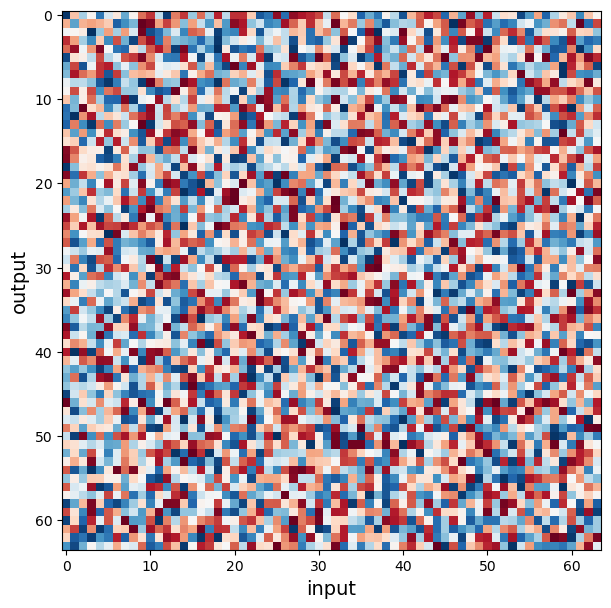

In [61]:
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, transfer_weights_taus, copy_snn
from snn_delays.utils.test_behavior import tb_save_max_last_acc

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                   caching='memory',
                   num_workers=0,
                   batch_size=batch_size,
                   total_time=total_time,
                   crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
          
num_epochs = 100

lr = 1e-3

tau_m = 'normal'
delay = (10,1)
ckpt_dir = 'exp14_shd50_pruned3' 

snn = Masked_SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='f',
    delay=delay, delay_type='h', tau_m = tau_m,
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=False, n_pruned_delays=3)

snn.set_network()

from snn_delays.utils.visualization_utils import plot_param
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot_param(snn.f1_f2.linear, '2D_square')


[INFO] Delays: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 20.0 ms
mean of normal: -0.541324854612918


<Axes: xlabel='input', ylabel='output'>

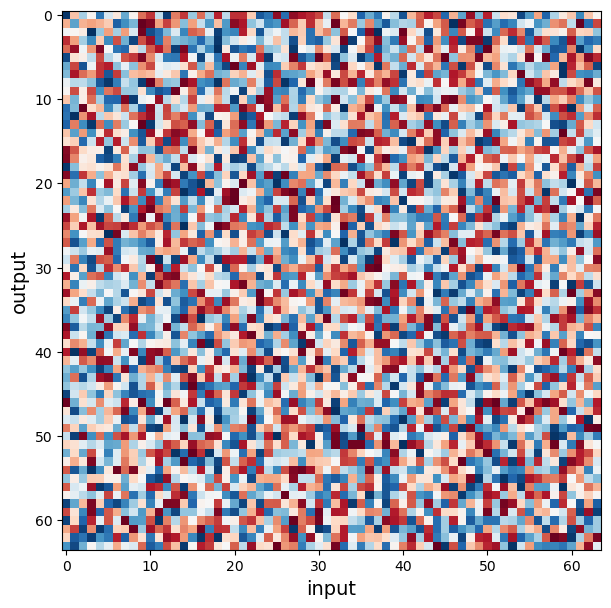

In [62]:
snn_base = copy_snn(snn)
plt.figure(figsize=(7,7))
plot_param(snn_base.f1_f2.linear, '2D_square')

In [63]:
pool_delays(snn_base, 'synaptic', 'h', k=3, freeze=True)

<Axes: xlabel='input', ylabel='output'>

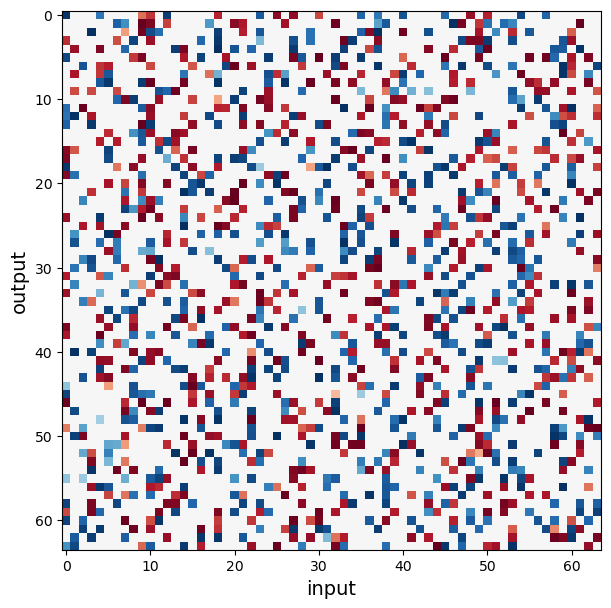

In [64]:
plt.figure(figsize=(7,7))
plot_param(snn_base.f1_f2.linear, '2D_square')

In [65]:
snn_base.f1_f2.linear.weight.shape

torch.Size([64, 640])

In [66]:
snn.to(device)
a, b = snn.test(test_loader, only_one_batch=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x640 and 64x640)

<Axes: xlabel='input', ylabel='output'>

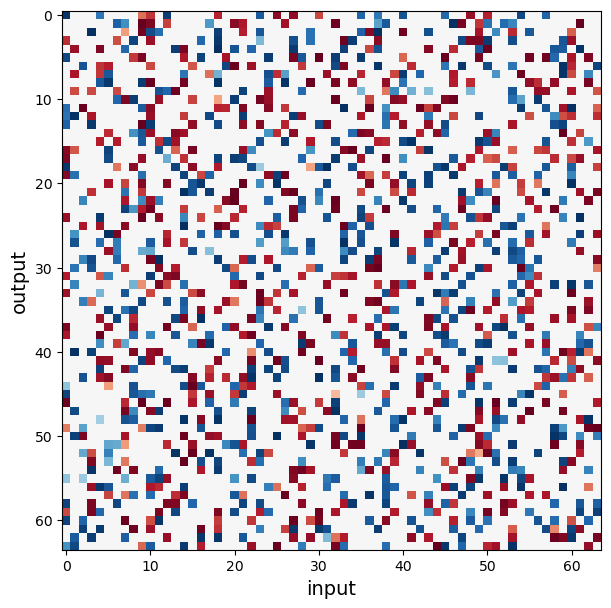

In [67]:
plt.figure(figsize=(7,7))
plot_param(snn.f1_f2._masked_projection, '2D_square')